In [16]:
from tensorflow import keras
#from keras.preprocessing import image

# for linux Ubuntu
from keras.utils import load_img, img_to_array

#base_image_path = keras.utils.get_file(
#    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
#style_reference_image_path = keras.utils.get_file(
#    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

#original_width, original_height = image.load_img(base_image_path).size
#img_height = 400 #400
#img_width = round(original_width * img_height / original_height)

<function matplotlib.pyplot.show(close=None, block=None)>

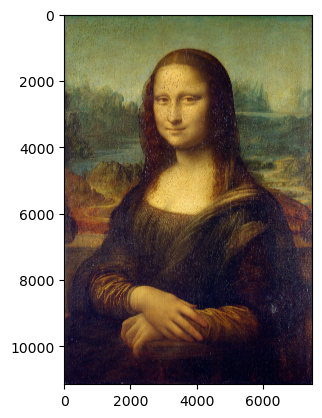

In [17]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("Mona.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

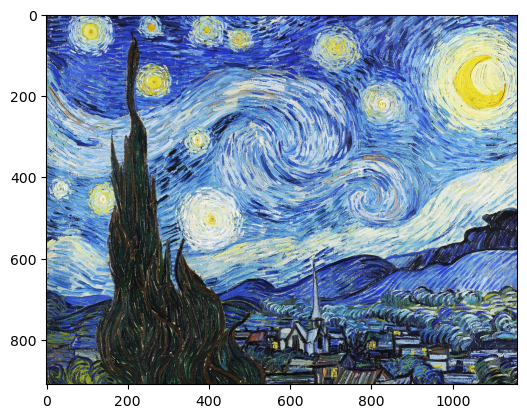

In [18]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("starry_night.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

In [25]:
import numpy as np
import keras.utils as image

def preprocess_image(image_path):
    img = image.load_img(
        image_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [26]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [27]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [28]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [29]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [30]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [36]:
import tensorflow as tf

base_image_path="./Mona.jpg"
style_reference_image_path = "./starry_night.jpg"

original_width, original_height = image.load_img(base_image_path).size
img_height = 400 #400
img_width = round(original_width * img_height / original_height)


@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 2000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        image.save_img(fname, img)

Iteration 10: loss=30588.91
Iteration 20: loss=15421.30
Iteration 30: loss=13596.90
Iteration 40: loss=11053.09
Iteration 50: loss=10417.93
Iteration 60: loss=9552.33
Iteration 70: loss=9770.87
Iteration 80: loss=9177.52
Iteration 90: loss=7807.99
Iteration 100: loss=7601.64
Iteration 110: loss=8651.84
Iteration 120: loss=7419.58
Iteration 130: loss=6892.17
Iteration 140: loss=7291.93
Iteration 150: loss=6737.23
Iteration 160: loss=6821.85
Iteration 170: loss=6454.28
Iteration 180: loss=6391.91
Iteration 190: loss=7047.64
Iteration 200: loss=6100.02
Iteration 210: loss=6005.36
Iteration 220: loss=5845.88
Iteration 230: loss=5848.68
Iteration 240: loss=6713.23
Iteration 250: loss=5786.85
Iteration 260: loss=5919.06
Iteration 270: loss=5551.50
Iteration 280: loss=5470.46
Iteration 290: loss=5476.44
Iteration 300: loss=5741.41
Iteration 310: loss=5660.09
Iteration 320: loss=5346.59
Iteration 330: loss=5278.70
Iteration 340: loss=5293.93
Iteration 350: loss=5190.06
Iteration 360: loss=5152

<function matplotlib.pyplot.show(close=None, block=None)>

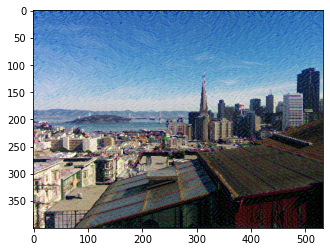

In [13]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("combination_image_at_iteration_10.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

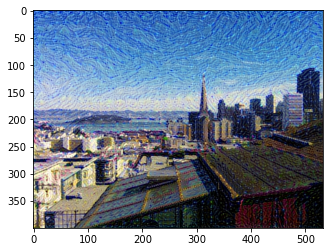

In [14]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("combination_image_at_iteration_200.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

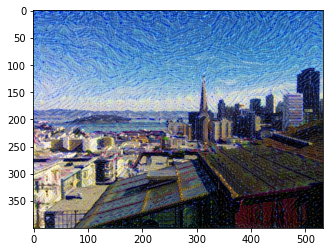

In [15]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("combination_image_at_iteration_300.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

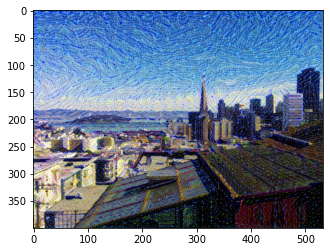

In [16]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("combination_image_at_iteration_400.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

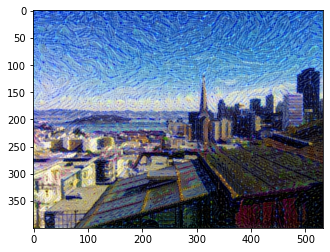

In [18]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("combination_image_at_iteration_800.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

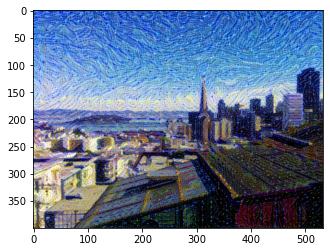

In [19]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("combination_image_at_iteration_1000.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

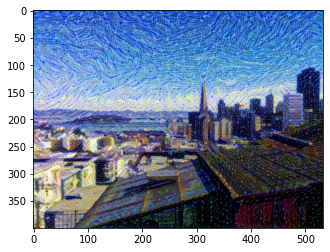

In [20]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("combination_image_at_iteration_1240.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show